# PROJET 5 : CATEGORISATION DES QUESTIONS 
#### AUTEUR : Fancpois Xavier Wockmatchieu
##  PARTIE II  : MODELISATION 

## SOMMAIRE 


### I. [TRANSFORMATION  DES DONNEES ](#transformation_donnees)<br>

a. [représentation du corpus](#rep_corpus)<br>
b. [représentation du BOW](#rep_bow)<br>
c. [représentation du TF-IDF  et réduction de dimension](#rep_TFIDF)<br>
d. [représentation multi-label  ](#rep_label)<br>


### II.  [APPROCHE NON SUPERVISEE : LDA  ](#approche_non_supervisee)<br>

a. [recherche du nombre optimun de topics](#optimun)<br>
b. [cohérence et perplexité](#cohérence)<br>
c. [topics générés du modele](#topics)<br>
d. [distribution de probabilité QUESTIONS-TOPICS  ](#questions-topics)<br>
e. [distribution de probabilité TOPICS-TAGS  ](#topics-tags)<br>
f. [tags prédits et précision du modele  ](#tags-predits)<br>




### III.  [APPROCHE SUPERVISEE   ](#approche_supervisee)<br>

a. [Echantillonnage](#echantillonnage)<br>
b. [KNN Classifier](#knn)<br>
c. [Logistic Regression Classifier](#logit)<br>
d. [Random Forest Classifier ](#rf)<br>
e. [Random Forest Classifier Chain  ](#rfc)<br>
f. [Comparaison des performances du modèle ](#compare_perf)<br>





In [36]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [37]:
import pandas as pd 
import numpy as np
import time
import re 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [38]:
#----------------> visualisation 
from matplotlib import pyplot as plt
import seaborn as sns

In [39]:
# t--------- traitement scikitlearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

#------------écantillonage 
from sklearn.model_selection import train_test_split


#---------- traitement gensim 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# visualisation des topics 
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))



In [41]:
#--------------- modelisation 
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score



##  chargement du fichier nettoyé 

In [42]:
post_data_clean = pd.read_csv("post_data_clean.csv",sep = ";")
post_data_clean.head(3)

,Id,stem_text,cleaned_tag,nb_tags
0,4,convert decim doubl c want use track bar chang...,"['c#', 'floating-point', 'type-conversion', 'd...",5
1,6,width collaps percentag width child element ab...,"['html', 'css', 'internet-explorer-7']",3
2,9,calcul someon age base datetim type birthday g...,"['c#', '.net', 'datetime']",3


## I <a class = "anchor" id = "transformation_donnees">    TRANSFORMATION DES DONNEES  <a/> 

### a. <a class = "anchor" id = "rep_corpus">  representation du corpus  <a/> 

In [43]:
def corpus_construction(question_stem) :
    n = len(question_stem)
    corpus = list()
   
    for j in np.arange(n) :
        corpus += question_stem[j].split()
    return corpus

In [44]:
word_corpus_data =  corpus_construction(post_data_clean["stem_text"])
corpus_data = pd.DataFrame({"word":word_corpus_data })
len(corpus_data)

3242602

### b. <a class = "anchor" id = "rep_bow">  representation BOW <a/> 

In [45]:
document_corpus = list(post_data_clean["stem_text"])
doc_tokenized = [simple_preprocess(doc) for doc in document_corpus]
dictionary = corpora.Dictionary(doc_tokenized)
BoW_corpus = [dictionary.doc2bow(doc, allow_update= True) for doc in doc_tokenized]

* les 2 premiers documents du bag of words

In [46]:
print(BoW_corpus[0:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 3), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2)]]


* les 2 premiers documents en representation (mot,frequence) du  bag of word

In [47]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
print(id_words[0:2])

[[('applic', 1), ('bar', 1), ('build', 1), ('cannot', 1), ('chang', 1), ('code', 2), ('control', 1), ('convert', 2), ('decim', 3), ('doubl', 3), ('error', 1), ('fine', 1), ('follow', 1), ('form', 1), ('give', 1), ('implicitli', 1), ('net', 1), ('opac', 2), ('past', 1), ('project', 1), ('track', 1), ('trackbar', 1), ('tran', 3), ('tri', 1), ('type', 1), ('use', 2), ('valu', 1), ('vb', 1), ('want', 1), ('work', 2)], [('use', 2), ('work', 2), ('absolut', 2), ('area', 1), ('base', 2), ('besid', 1), ('child', 4), ('children', 1), ('collaps', 2), ('contain', 1), ('cover', 1), ('css', 1), ('div', 3), ('easi', 1), ('element', 1), ('explor', 1), ('firefox', 1), ('fix', 1), ('ie', 1), ('internet', 1), ('miss', 1), ('one', 1), ('parent', 2), ('percentag', 3), ('pixel', 2), ('posit', 4), ('rel', 2), ('safari', 1), ('sever', 1), ('someth', 1), ('specif', 1), ('width', 7)]]


### c. <a class = "anchor" id = "rep_TFIDF"> représentation du TF-IDF  et réduction de dimension <a/> 

* recherche du seuil de réduction de sa dimension

In [48]:
def corpus_construction(question_stem) :
    n = len(question_stem)
    corpus = list()
   
    for j in np.arange(n) :
        corpus += question_stem[j].split()
    return corpus

In [49]:
corpus_data_stat  = pd.DataFrame({"word" : corpus_data["word"].value_counts().index,"nb_occurence":corpus_data["word"].value_counts().values})
corpus_data_stat

,word,nb_occurence
0,use,53496
1,like,24505
2,file,23359
3,c,20859
4,code,20692
...,...,...
79990,qtsql,1
79991,columng,1
79992,cppdefin,1
79993,excepion,1


In [50]:
corpus_data_stat["nb_occurence"].describe()

count    79995.000000
mean        40.535058
std        465.567925
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max      53496.000000
Name: nb_occurence, dtype: float64

In [51]:
corpus_data_stat.iloc[200:205]

,word,nb_occurence
200,show,3197
201,support,3188
202,allow,3182
203,input,3179
204,order,3175


Text(0, 0.5, 'nombre de variables ')

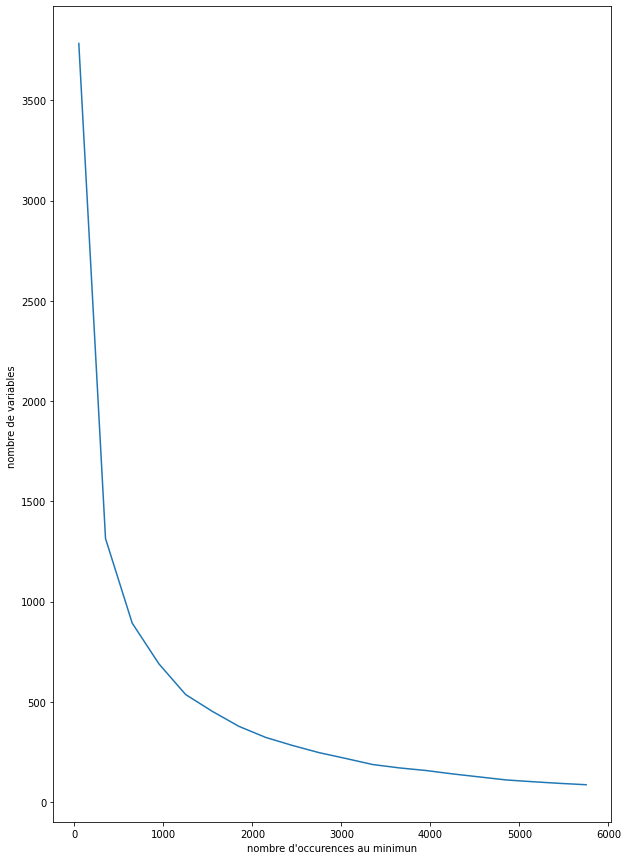

In [52]:
list_nvars = list()
for nb in np.arange(50,6000,300) :
    list_nvars.append(len(corpus_data_stat[corpus_data_stat["nb_occurence"]> nb]))
    
# list_nvars   
# occurence_variation = pd.DataFrame({"occurence":np.arange(1000,6000,300),"nb_variables":np.arange(1000,6000,300)})
plt.figure(figsize = (10,15))
sns.lineplot( x =np.arange(50,6000,300),y=list_nvars, ci=None)
plt.xlabel("nombre d\'occurences au minimun",fontsize = 10)
plt.ylabel("nombre de variables ",fontsize = 10)

In [53]:
corpus_data_stat.iloc[650:655]

,word,nb_occurence
650,rang,1006
651,commun,1002
652,enum,999
653,extend,998
654,merg,997


* réduction au 650 mots les plus fréquents 

In [54]:
vectorizer = TfidfVectorizer(max_features = 650)
X = vectorizer.fit_transform(document_corpus)

In [77]:
tab =vectorizer.get_feature_names()
TFIDF = X.copy()
TFIDF = TFIDF.todense()
data_tf_idf = pd.DataFrame(TFIDF,columns = tab)
data_tf_idf.head(3)

,abl,accept,access,account,across,action,activ,actual,ad,add,...,would,wpf,write,written,wrong,www,xml,ye,year,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261231,0.0


In [78]:
data_tf_idf.shape

(48883, 650)

* traitement des labels et choix des labels les plus fréquents 

In [79]:
def cleannning_tag(tags):
    return re.findall(r'(?<=\<)[^\<\>]+(?=\>)', tags)
post_data =   pd.read_csv("FILE_QUESTIONS.txt",sep = ",",header = 0)
post_data["cleaned_tag"] = post_data["Tags"].apply(cleannning_tag)
post_data_clean["cleaned_tag"] = post_data["cleaned_tag"]

In [80]:
def construct_coepora_tags(post_data) :
    tags_data = list()
    n_posts = post_data.shape[0]
    for post in np.arange(n_posts) :
        tags_data += post_data.loc[post,"cleaned_tag"]
    return tags_data

In [81]:
corpora_tags = construct_coepora_tags(post_data_clean)
corpo_tags = pd.DataFrame({"tags":corpora_tags})
data_tags = pd.DataFrame({"tag":corpo_tags["tags"].value_counts().index,"nombre occurence":corpo_tags["tags"].value_counts().values})
data_tags

,tag,nombre occurence
0,c#,6952
1,.net,4908
2,java,4221
3,c++,3056
4,python,2591
...,...,...
9047,lr1,1
9048,sqltransaction,1
9049,eeepc,1
9050,zxspectrum,1


### d. <a class = "anchor" id = "rep_label"> représentation multi-label <a/> 

* réduction de dimension et harmoisation 

In [82]:
tags_most_freq = list(data_tags["tag"])
useful_frequent_tags = tags_most_freq[0:50]
tags = list(post_data_clean["cleaned_tag"])
used_tags = list()
for ts in tags:
    used_tags.append([word for word in ts if word in useful_frequent_tags])
used_tags = np.array(used_tags,dtype = "object")
empty_index = np.array([i for i in range(0, len(used_tags)) if not used_tags[i]]).astype(int)
is_not_empty = ~np.in1d(np.arange(0, len(used_tags)), empty_index)
used_tags = used_tags[is_not_empty]
data_tf_idf = data_tf_idf[is_not_empty]
y = list(used_tags)


In [83]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

In [84]:
y_binarized.shape

(39488, 50)

In [85]:
len(BoW_corpus)

48883

## II. <a class = "anchor" id = "approche_non_supervisee"> APPRENTISSAGE NON SUPPERVISE : LDA <a/> 

* Préparation ds parametres 

In [64]:
id2word = corpora.Dictionary(doc_tokenized)
texts = doc_tokenized
#corpus = list(reduced_BoW_corpus)
corpus = list(BoW_corpus)




###  a. <a class = "anchor" id = "optimun"> recherche du nombre optimun de topics <a/> 


In [65]:
complete_evaluation = []
coherence_values = []
coherence_perplexity = []
model_list = []
for k in np.arange(2,92,4):
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=2)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    perplexity_mod = lda_model.log_perplexity(corpus)
    model_list.append(lda_model)
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_perplexity.append((k,perplexity_mod))
    coherence_values.append((k, coherence_lda,
                           (end_time - start_time)))
    complete_evaluation.append((k, coherence_lda,perplexity_mod,
                           (end_time - start_time)))
    print("Ajustement réussi pour k ={}".format(k))

Ajustement réussi pour k =2
Ajustement réussi pour k =6
Ajustement réussi pour k =10
Ajustement réussi pour k =14
Ajustement réussi pour k =18
Ajustement réussi pour k =22
Ajustement réussi pour k =26
Ajustement réussi pour k =30
Ajustement réussi pour k =34
Ajustement réussi pour k =38
Ajustement réussi pour k =42
Ajustement réussi pour k =46
Ajustement réussi pour k =50
Ajustement réussi pour k =54
Ajustement réussi pour k =58
Ajustement réussi pour k =62
Ajustement réussi pour k =66
Ajustement réussi pour k =70
Ajustement réussi pour k =74
Ajustement réussi pour k =78
Ajustement réussi pour k =82
Ajustement réussi pour k =86
Ajustement réussi pour k =90


* évaluation

In [67]:
# Create dataframe of results
coherence_test = pd.DataFrame(complete_evaluation,
                              columns=["k","coherence","perplexity","time"])


### b. <a class = "anchor" id = "cohérence"> cohérence et perplexité <a/> 

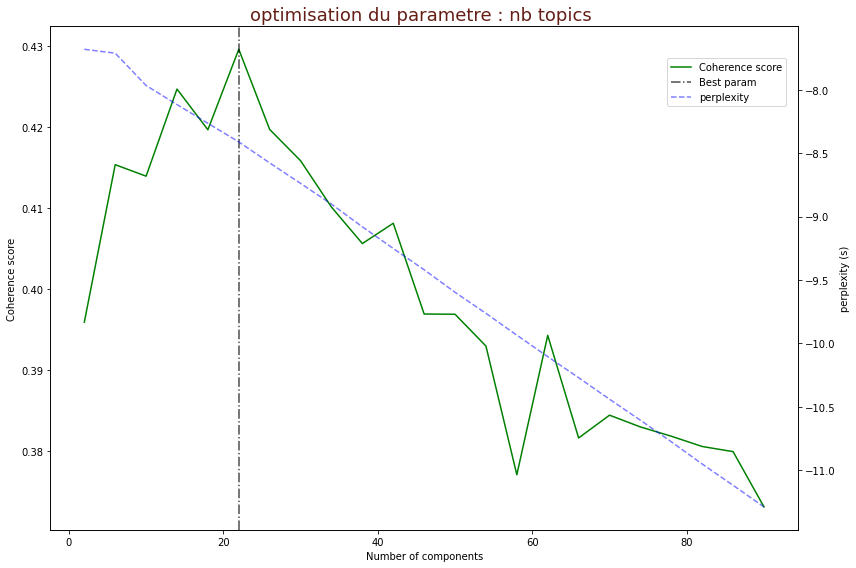

In [73]:


# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]
#y3 = coherence_test["perplexity"]

ax1.plot(x, y1, label="Coherence score",color='green')
ax1.axvline(x=best_nb_topics, color='black', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")



ax2 = ax1.twinx()
ax2.plot(x, y3, label="perplexity",
         color='blue', alpha=.5,
         linestyle='--')
ax2.set_ylabel("perplexity (s)")

plt.title("optimisation du parametre : nb topics ",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()



In [74]:
#best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]
nb_optimun = coherence_test.loc[coherence_test.coherence.argmax(),"k"]
nb_optimun 

22

#### visualisation du modele 

In [75]:
best_lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics= nb_optimun,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=2)




### c. <a class = "anchor" id = "topics"> topics générés du modele <a/> 

In [76]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(best_lda_model, corpus, id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.017966  0.027415       1        1  10.327619
11     0.163431 -0.060537       2        1   9.162448
19    -0.079124 -0.009094       3        1   7.000355
1     -0.067280  0.025599       4        1   6.545129
5      0.124879 -0.046029       5        1   5.433325
14     0.013883  0.069417       6        1   5.409069
18    -0.027519  0.070396       7        1   5.274984
10    -0.024804  0.030404       8        1   5.196537
15     0.137286  0.100532       9        1   4.641800
8      0.032880  0.054754      10        1   4.530907
21    -0.031928  0.031993      11        1   3.801292
6     -0.062012  0.059666      12        1   3.598036
3     -0.083195 -0.022593      13        1   3.453391
0      0.000142 -0.011573      14        1   3.373830
20     0.029503  0.075136      15        1   3.234827
2     -0.104514 -0.044026      16        1   2.971870
4     -0.018335 -0.084058      17        1   2.906923
9      0.034015 -0.019309      18        1   2.801596
13     0.027400 -0.135683      19        1   2.793253
17     0.049923 -0.027741      20        1   2.618611
12    -0.061476 -0.020031      21        1   2.576638
16    -0.035192 -0.064638      22        1   2.347561, topic_info=       Term          Freq         Total Category  logprob  loglift
214    test  10640.000000  10640.000000  Default  30.0000  30.0000
248    file  23459.000000  23459.000000  Default  29.0000  29.0000
350   class  17190.000000  17190.000000  Default  28.0000  28.0000
700    java  11267.000000  11267.000000  Default  27.0000  27.0000
118  public   9565.000000   9565.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
380  exampl    324.017976   9824.818022  Topic22  -5.4307   0.3399
73     like    355.242524  25308.012617  Topic22  -5.3387  -0.5143
0    applic    324.762704  13585.512732  Topic22  -5.4284   0.0181
249    find    299.007134   8205.659202  Topic22  -5.5110   0.4397
223   would    303.736103  21309.928994  Topic22  -5.4953  -0.4990

[1943 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
7124      22  0.935035    abcdef
1904       1  0.095480  abstract
1904       2  0.693421  abstract
1904       3  0.003580  abstract
1904       4  0.045353  abstract
...      ...       ...       ...
17594     17  0.910592  zipentri
6994       7  0.766482    zipfil
6994      20  0.222815    zipfil
11204      7  0.973834       zsh
15014     21  0.929529        zx

[13503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 12, 20, 2, 6, 15, 19, 11, 16, 9, 22, 7, 4, 1, 21, 3, 5, 10, 14, 18, 13, 17])

In [50]:
p = gensimvis.prepare(best_lda_model, corpus, id2word)
pyLDAvis.save_html(p, 'lda_tag.html')

In [51]:
#gensimvis.prepare(best_lda_model, corpus, id2word)



### d. <a class = "anchor" id = "questions-topics"> distribution de probabilité QUESTIONS-TOPICS  <a/> 

In [86]:
question_topic = pd.DataFrame(best_lda_model.get_document_topics(corpus,minimum_probability=0))
question_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,"(0, 0.0010845334)","(1, 0.0010845334)","(2, 0.0010845334)","(3, 0.0010845334)","(4, 0.0010845334)","(5, 0.6084294)","(6, 0.0010845334)","(7, 0.06469165)","(8, 0.0010845334)","(9, 0.0010845334)",...,"(12, 0.0010845334)","(13, 0.0010845334)","(14, 0.0010845334)","(15, 0.0010845334)","(16, 0.0010845334)","(17, 0.0010845334)","(18, 0.0010845334)","(19, 0.30627286)","(20, 0.0010845334)","(21, 0.0010845334)"
1,"(0, 0.0007975968)","(1, 0.0007975968)","(2, 0.0007975968)","(3, 0.0007975968)","(4, 0.0007975968)","(5, 0.0007975968)","(6, 0.0007975968)","(7, 0.0007975968)","(8, 0.9832505)","(9, 0.0007975968)",...,"(12, 0.0007975968)","(13, 0.0007975968)","(14, 0.0007975968)","(15, 0.0007975968)","(16, 0.0007975968)","(17, 0.0007975968)","(18, 0.0007975968)","(19, 0.0007975968)","(20, 0.0007975968)","(21, 0.0007975968)"
2,"(0, 0.0028432936)","(1, 0.0028432936)","(2, 0.0028432936)","(3, 0.0028432936)","(4, 0.0028432936)","(5, 0.0028432936)","(6, 0.0028432936)","(7, 0.4117313)","(8, 0.0028432936)","(9, 0.0028432936)",...,"(12, 0.0028432936)","(13, 0.0028432936)","(14, 0.0028432936)","(15, 0.0028432936)","(16, 0.0028432936)","(17, 0.0028432936)","(18, 0.0028432936)","(19, 0.0028432936)","(20, 0.0028432936)","(21, 0.0028432936)"


In [53]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [54]:
def quantify_doc_topic(tuple_topic) :
    quantity_topic = tuple_topic[1]
    return  quantity_topic

In [55]:
for top in question_topic :
    question_topic[top] = question_topic[top].apply(quantify_doc_topic)
question_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.001085,0.001085,0.001085,0.001085,0.001085,0.608429,0.001085,0.064691,0.001085,0.001085,...,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.001085,0.306274,0.001085,0.001085
1,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.983250,0.000798,...,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798,0.000798
2,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843,0.411786,0.002843,0.002843,...,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843,0.002843


In [56]:
question_topic.shape

(48883, 22)

In [57]:
data_tags.iloc[99:102,:]

,tag,nombre occurence
99,events,206
100,apache-flex,206
101,internet-explorer,205


on table sur les 100 premiers tags où chacun a une occurence de plus de 200 !

In [58]:
useful_tags = list(data_tags.loc[0:99,"tag"])
len(useful_tags)

100

In [103]:
len(list(data_tags["tag"]))

9052

In [105]:
np.unique(list(data_tags["tag"])).shape

(9052,)

* vectorisation des tags

In [114]:
question_tag_vect = list()
n = post_data_clean["cleaned_tag"].shape[0]
for k in np.arange(n):
    tag_quesion = post_data_clean["cleaned_tag"][k]
    list_question = list()
    for word in useful_tags :
        if word in tag_quesion :
            list_question.append(1)
        else :
             list_question.append(0)
    question_tag_vect.append(list_question)
            
question_tag_useful_data = pd.DataFrame(question_tag_vect,columns = useful_tags )       

In [115]:
question_tag_useful_data.head(3)

,c#,.net,java,c++,python,javascript,asp.net,php,sql,sql-server,...,iis,ide,data-structures,stl,validation,compiler-construction,email,serialization,architecture,events
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
question_tag_useful_data.shape

(48883, 100)

In [117]:
question_topic.shape

(48883, 22)

In [118]:
question_tag_array = question_tag_useful_data.values
question_topic_array = question_topic.values

In [119]:
topic_tag_mul = np.matmul(question_topic_array.T,question_tag_array)

In [120]:
topic_tag_mul[0]

array([264.82245779, 185.03657966, 123.36090994,  86.11855862,
        90.32178426, 102.18531109,  50.32552166,  91.29544113,
        29.9716968 ,  30.07218151,  49.2375699 ,  28.25230851,
        33.4746094 ,  56.6992562 ,  11.37083874,  19.2926785 ,
        20.36732531,  21.37641042,   5.46620736,  11.75650914,
        31.9764347 ,  30.12814524,  10.23014018,  26.1338517 ,
        15.12173991,  10.29247327,  17.34422369,  29.08353425,
         7.19936373,  27.11760708,  10.4094437 ,  18.97002135,
       207.48808836,  16.69375755,  14.33971108,  19.37012307,
        15.7908449 ,   6.01187391,   5.26795761,   6.97392326,
         5.70874145,   3.81174209,  17.70371173,  18.26442693,
         9.40466395,  51.49412326,   8.02388462,   6.13762223,
        14.19476168,  10.09741062,   8.57217043,  23.61384313,
        29.86720542,  11.19171269,  10.84944882,  16.5691447 ,
         7.33955166,   2.78274401,  10.98880162,   8.41724256,
         2.98391277,  12.9428874 ,  10.58486787,   8.22


* transformation en une distribution de prpbabilité 

In [121]:
def proba_transform(x,axis = 0) : 
    proba_dist = x/x.sum()
    return proba_dist

In [68]:
topic_tag_proba_dist = np.apply_along_axis(proba_transform,1,topic_tag_mul)
topic_tag_proba_dist 

array([[0.10977308, 0.07670058, 0.05113504, ..., 0.00125588, 0.00223919,
        0.00391118],
       [0.06786347, 0.07203151, 0.12665006, ..., 0.00507291, 0.00693036,
        0.00083675],
       [0.09300578, 0.11816226, 0.06567658, ..., 0.00197597, 0.00076244,
        0.00095168],
       ...,
       [0.09605473, 0.08691632, 0.05637576, ..., 0.00069071, 0.00116365,
        0.00084366],
       [0.11277182, 0.08609934, 0.04793301, ..., 0.00511696, 0.01081292,
        0.0018077 ],
       [0.06685739, 0.04818055, 0.05607996, ..., 0.00100579, 0.00282414,
        0.00079015]])

In [69]:
topic_tag_proba_dist.shape

(22, 100)

In [70]:
for i in np.arange(5):
    print(round(topic_tag_proba_dist[i].sum()))


1
1
1
1
1




### e. <a class = "anchor" id = "topics-tags"> distribution de probabilité TOPICS-TAGS   <a/> 

In [72]:
topic_tag_view = pd.DataFrame(topic_tag_proba_dist ,columns = list(question_tag_useful_data.columns) )
# correspondance si la proba 

In [73]:
topic_tag_view.head(4)

,c#,.net,java,c++,python,javascript,asp.net,php,sql,sql-server,...,iis,ide,data-structures,stl,validation,compiler-construction,email,serialization,architecture,events
0,0.109773,0.076701,0.051135,0.035697,0.037440,0.042357,0.020861,0.037843,0.012424,0.012465,...,0.002375,0.000427,0.001958,0.001532,0.005129,0.001972,0.019671,0.001256,0.002239,0.003911
1,0.067863,0.072032,0.126650,0.056083,0.039223,0.016316,0.012589,0.012751,0.006119,0.006891,...,0.001838,0.008560,0.004203,0.001819,0.000889,0.003995,0.000922,0.005073,0.006930,0.000837
2,0.093006,0.118162,0.065677,0.049371,0.024718,0.012273,0.020163,0.011820,0.004516,0.009753,...,0.004602,0.009217,0.001206,0.001518,0.000720,0.006501,0.000690,0.001976,0.000762,0.000952
3,0.063845,0.049911,0.143717,0.013462,0.030392,0.046391,0.048009,0.047007,0.006830,0.004859,...,0.013378,0.000830,0.001047,0.000650,0.002502,0.001617,0.004952,0.002318,0.001447,0.000940


In [74]:
####  VOIR DANS QUELLE MESURE PRENDRE LES 2 OU 3 PREMIERS TAGS 

In [75]:
corr_topic_tag = topic_tag_view.idxmax(axis = 1, skipna = True)
np.unique(corr_topic_tag)

array(['.net', 'c#', 'c++', 'css', 'database', 'java', 'javascript',
       'python', 'sql', 'sql-server', 'unit-testing'], dtype=object)

In [76]:
np.unique(corr_topic_tag)

array(['.net', 'c#', 'c++', 'css', 'database', 'java', 'javascript',
       'python', 'sql', 'sql-server', 'unit-testing'], dtype=object)

##### En caractérisant chaque topic par un seul tag , celui de probabilité élevée ,on a plusieurs topics qui reposent sur le meme tag
##### on constate bien une perte énorme de pouvoir de prédiction dans la liaison entre le topic prédit et sa correspondance à un tag précis 


##### SOLUTION :  attribution à la question , le meme nombre de tags attendus correspondante dans l'ordre croissant de la distribution des probabilités des tags pour son meilleur topic prédit 

* caracterisation des topics par des tags 

In [81]:
post_data_clean.head(2)

,Id,stem_text,cleaned_tag,nb_tags
0,4,convert decim doubl c want use track bar chang...,"[c#, floating-point, type-conversion, double, ...",5
1,6,width collaps percentag width child element ab...,"[html, css, internet-explorer-7]",3


In [82]:
post_data_clean["best_topic"] = question_topic.idxmax(axis = 1).values

In [83]:
post_data_clean.head(2)

,Id,stem_text,cleaned_tag,nb_tags,best_topic
0,4,convert decim doubl c want use track bar chang...,"[c#, floating-point, type-conversion, double, ...",5,5
1,6,width collaps percentag width child element ab...,"[html, css, internet-explorer-7]",3,8


In [100]:
def corresponding_tags_for_best_topic(question) :
    topic_tag = topic_tag_view
    nb_tag = question["nb_tags"]
    topic = question["best_topic"]
    
    best_topic_t = topic_tag.iloc[topic].values.tolist()
    toptag = pd.DataFrame({"tags":list(topic_tag.iloc[topic].index),"probability": topic_tag.iloc[topic].values.tolist()})
    toptag  = toptag.sort_values(by = "probability",ascending = False)
    toptag = toptag.reset_index()
    list_predicted_tags = toptag.loc[0:nb_tag -1,"tags"].values.tolist()
    
    return list_predicted_tags
    


### f. <a class = "anchor" id = "tags-predits"> tags prédits et précision du modele  <a/> 

In [86]:
post_data_clean["predicted_tags"] = post_data_clean.apply(corresponding_tags_for_best_topic,axis = 1)

In [87]:
post_data_clean.head(2)

,Id,stem_text,cleaned_tag,nb_tags,best_topic,predicted_tags
0,4,convert decim doubl c want use track bar chang...,"[c#, floating-point, type-conversion, double, ...",5,5,"[c++, c#, c, javascript, java]"
1,6,width collaps percentag width child element ab...,"[html, css, internet-explorer-7]",3,8,"[css, html, javascript]"


In [93]:
tab_class = list(data_tags["tag"])
def tag_multilabelisation_base(list_tags) :
    num_list = list()
    for tag in list_tags :
        num_tag = tab_class.index(tag)
        num_list.append(num_tag)
    return num_list
    
tag_multilabelisation_base(['c#', 'floating-point', 'type-conversion', 'double', 'decimal'])  

[0, 224, 648, 679, 632]

In [94]:
post_data_clean["y_lda_predicted"] = post_data_clean["predicted_tags"].apply(tag_multilabelisation_base)
post_data_clean["y_tag_question"] = post_data_clean["cleaned_tag"].apply(tag_multilabelisation_base)

In [95]:
post_data_clean.head(2)

,Id,stem_text,cleaned_tag,nb_tags,best_topic,predicted_tags,y_lda_predicted,y_tag_question
0,4,convert decim doubl c want use track bar chang...,"[c#, floating-point, type-conversion, double, ...",5,5,"[c++, c#, c, javascript, java]","[3, 0, 10, 5, 2]","[0, 224, 648, 679, 632]"
1,6,width collaps percentag width child element ab...,"[html, css, internet-explorer-7]",3,8,"[css, html, javascript]","[18, 11, 5]","[11, 18, 490]"


In [98]:
 precision_score(post_data_clean["y_tag_question"][1],post_data_clean["y_lda_predicted"][1],average = 'weighted')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [99]:
sum_prec = 0

for q in np.arange(post_data_clean.shape[0]) :
    sum_prec  += precision_score(post_data_clean["y_tag_question"][q],post_data_clean["y_lda_predicted"][q],average = 'weighted')
    
prec =(sum_prec)/post_data_clean.shape[0]
print("precision du modele LDA :  {}".format(prec))

precision du modele LDA :  0.0754706816957511


#### la précision étant tres faible , inutile d'évaluer son score F1 car le modèle.  obligation de seretourner vers d'autres modeles 


## III. <a class = "anchor" id = "approche_supervisee"> APPROCHE SUPERVISEE  <a/>


In [70]:
list_model = list()
list_pred = list()
list_pred_tag = list()
list_real_tag = list()
list_performance = list()


### a. <a class = "anchor" id = "echantillonnage"> échantillonage des données <a/>

In [91]:
reduced_tfidf = data_tf_idf
X_tfidf = np.array(reduced_tfidf).copy()
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,test_size=0.3, random_state=12)
print("X_train  : ",X_train.shape,"X_test :",X_test.shape)
print("y_train :" ,y_train.shape,"y_test  :",y_test.shape)

X_train  :  (27641, 650) X_test : (11847, 650)
y_train : (27641, 50) y_test  : (11847, 50)


* liste de predictions par modeles 

In [92]:
def predicted_expected_tag(predicted,expected) :
    predicted_tags = multilabel_binarizer.inverse_transform(predicted) 
    expected_tags = multilabel_binarizer.inverse_transform(expected) 
    return (predicted_tags,expected_tags )
    

In [93]:
def metric_evaluation(y_real,y_pred) :
    dict_eval = dict()
    dict_eval["eval_accuracy"] = accuracy_score( y_real,y_pred)
    dict_eval["eval_precision"] = precision_score(y_real,y_pred, average='weighted')
    dict_eval["eval_recall"] = recall_score(y_real,y_pred, average='weighted',labels=np.unique(y_pred))
    dict_eval["eval_F1"] = f1_score(y_real,y_pred, average='weighted')
    dict_eval["eval_jaccard"] =  jaccard_score(y_real,y_pred, average='weighted')
    
    
    return dict_eval
    

In [94]:
def model_synthesis(model_name,X_test,y_test,y_predicted) :
    list_model = list()
    list_test = list()
    list_pred = list()
    list_pred_tag = list()
    list_real_tag = list()
    list_perf = list()

    y_tag_pred = predicted_expected_tag(y_predicted,y_test)[0]
    y_tag_real = predicted_expected_tag(y_predicted,y_test)[1]
    list_model.append(str(model_name))
    list_pred.append(y_predicted)
    list_test.append(y_test)
    list_pred_tag.append(y_tag_pred)
    list_real_tag.append(y_tag_real)
    perf = metric_evaluation(y_test,y_predicted)
    list_perf.append(perf)
    model_resume = pd.DataFrame({"model" : list_model,"predicted_tag":list_pred_tag,"real_tag":list_real_tag,"perf_evalmuation":list_perf})
    return model_resume
    

In [95]:
def models_collecting(resume_1,resume_2) :
    collect_model = pd.concat([resume_1,resume_2])
    return collect_model

In [96]:
def display_model_predictions(set_models,model_name,nb_predictions) :
    tab_real = set_models.loc[set_models["model"] == model_name]["real_tag"][0:]
    tab_real = list(tab_real)[0][0:nb_predictions]
    tab_pred = set_models.loc[set_models["model"] == model_name]["predicted_tag"][0:]
    tab_pred = list(tab_pred)[0][0:nb_predictions]
    print("++++++++++ premiers tags rééls   ++++++++++++")
    for tags in  tab_real :
        print(tags)
    print("++++++++++  premiers tags predits   ++++++++++++")
    for tags in  tab_pred :
        print(tags)
       

In [97]:
def performance_modele_evaluation(set_models,model_name) :
    model_perf = set_models.loc[set_models["model"] == model_name]["perf_evalmuation"]
    perf = list(model_perf)[0]
    multi_eval = pd.DataFrame.from_dict(perf,orient = "index",columns= ["performance"])
    return multi_eval
    

### b. <a class = "anchor" id = "knn"> KNN Classifier<a/>

In [ ]:
grid_param = { "leaf_size" : [30,40,50],
               "n_neighbors" : [6,8,10],
               "p": [1,2]}

KNN_cv = GridSearchCV(estimator = KNeighborsClassifier(),
                              param_grid = grid_param,
                               cv=5,
                              n_jobs=-1,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
KNN_cv.fit(X_train, y_train)




In [99]:
y_pred_knn = KNN_cv.predict(X_test)
model_knn = model_synthesis("knn",X_test,y_test,y_pred_knn) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

###### un apercu des prédictions faites par le modele 

In [101]:
display_model_predictions(model_knn,"knn",8) 

++++++++++ premiers tags rééls   ++++++++++++
('python', 'windows')
('multithreading',)
('java', 'php')
('mysql', 'sql')
('css',)
('c#', 'linq')
('asp.net', 'sql-server')
('c#', 'performance')
++++++++++  premiers tags predits   ++++++++++++
('python',)
()
('java',)
('.net',)
()
('c#', 'linq')
('sql', 'sql-server')
('c++',)


###### performance du modele 

In [310]:
perf_knn =  performance_modele_evaluation(model_knn,"knn") 
perf_knn

,performance
eval_accuracy,0.131426
eval_precision,0.640782
eval_recall,0.157317
eval_F1,0.296470
eval_jaccard,0.182175



### c. <a class = "anchor" id = "logit"> Logistic Regression  Classifier<a/>

In [168]:
grid_param = { "estimator__penalty" : ["l1","l2"],
               "estimator__C" : [0.1,1.0,10,100],
               "estimator__solver": ["liblinear"]}


logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid = grid_param,
                               cv=5,
                              n_jobs=-1,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
logit_cv.fit(X_train[0:20000], y_train[0:20000])

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1.0, 10, 100],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [311]:
y_pred_logit_cv = logit_cv.predict(X_test)
logistic_model = model_synthesis("logistic_regression",X_test,y_test,y_pred_logit_cv) 
models_collected = models_collecting(model_knn,logistic_model) 
models_collected.reset_index(drop = True,inplace = True)

###### un apercu des prédictions faites par le modele 

In [312]:
display_model_predictions(models_collected,"logistic_regression",10) 

++++++++++ premiers tags rééls   ++++++++++++
('python', 'windows')
('multithreading',)
('java', 'php')
('mysql', 'sql')
('css',)
('c#', 'linq')
('asp.net', 'sql-server')
('c#', 'performance')
('.net', 'c#')
('c++',)
++++++++++  premiers tags predits   ++++++++++++
('python',)
('multithreading',)
('java', 'php')
('mysql',)
()
('c#', 'linq')
('sql-server',)
('c++',)
('.net', 'c#')
()


###### performance du modele 

In [313]:
perf_logistic_regresion =  performance_modele_evaluation(models_collected,"logistic_regression") 
perf_logistic_regresion 

,performance
eval_accuracy,0.324977
eval_precision,0.688076
eval_recall,0.367683
eval_F1,0.570741
eval_jaccard,0.423933


### d. <a class = "anchor" id = "rf"> Random Forest  Classifier<a/>

In [88]:
grid_param = {"estimator__min_samples_leaf": [1, 5, 10],
              "estimator__max_depth": [5, 15, 25,50],
             "estimator__class_weight": ["balanced"]}

RF_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid = grid_param,
                            cv = 3,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            n_jobs = -1,
                            verbose = 5
                    )

RF_cv.fit(X_train[0:4500], y_train[0:4500])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 17.3min finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 15, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=5)

In [89]:
best_param_useful = dict()
for parameter,value in RF_cv.best_params_.items() :
    used_param = parameter.replace("estimator__","")
    best_param_useful[used_param] =  value
best_param_useful

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10}

* entrainement du modele optimisé 

In [90]:

RF_best_model  = OneVsRestClassifier(RandomForestClassifier(**best_param_useful))
RF_best_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     min_samples_leaf=10))

In [314]:
y_pred_RF_best_model = RF_best_model.predict(X_test)
Random_Forest_model = model_synthesis("Random_Forest",X_test,y_test,y_pred_RF_best_model) 
models_collected = models_collecting(models_collected,Random_Forest_model) 

###### un apercu des prédictions faites par le modele 

In [315]:
display_model_predictions(models_collected,"Random_Forest",10) 

++++++++++ premiers tags rééls   ++++++++++++
('python', 'windows')
('multithreading',)
('java', 'php')
('mysql', 'sql')
('css',)
('c#', 'linq')
('asp.net', 'sql-server')
('c#', 'performance')
('.net', 'c#')
('c++',)
++++++++++  premiers tags predits   ++++++++++++
('c', 'macos', 'python', 'windows')
('c', 'java', 'language-agnostic', 'linux', 'multithreading', 'oop', 'performance')
('c', 'php', 'xml')
('database', 'linq', 'mysql', 'sql', 'sql-server')
('asp.net', 'css', 'html', 'javascript')
('.net', 'c#', 'linq', 'sql')
('sql', 'sql-server')
('c#', 'c++', 'oop', 'performance')
('.net', 'c#')
('c', 'c#', 'c++')


In [316]:
perf_Random_Forest =  performance_modele_evaluation(models_collected,"Random_Forest") 
perf_Random_Forest

,performance
eval_accuracy,0.071326
eval_precision,0.420530
eval_recall,0.697561
eval_F1,0.530434
eval_jaccard,0.378783



### e. <a class = "anchor" id = "rfc"> Random Forest  Classifier Chain <a/>

In [94]:
RF_classic = RandomForestClassifier(**best_param_useful)
chain_RF = ClassifierChain(RF_classic, order='random')
chain_RF.fit(X_train, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                      max_depth=5,
                                                      min_samples_leaf=10),
                order='random')

In [317]:
y_pred_chain_rf = chain_RF.predict(X_test)
Random_Forest_chain_model = model_synthesis("Random_Forest_classifier_chain",X_test,y_test,y_pred_chain_rf) 
models_collected = models_collecting(models_collected,Random_Forest_chain_model) 
models_collected.reset_index(inplace = True, drop = True)

In [318]:
models_collected

,model,predicted_tag,real_tag,perf_evalmuation
0,knn,"[(python,), (), (java,), (.net,), (), (c#, lin...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.13142567738668018, 'eval_p..."
1,logistic_regression,"[(python,), (multithreading,), (java, php), (m...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.32497678737233054, 'eval_p..."
2,Random_Forest,"[(c, macos, python, windows), (c, java, langua...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.07132607411158944, 'eval_p..."
3,Random_Forest_classifier_chain,"[(macos, python, windows), (c, c++, linux, mul...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.05672322106862497, 'eval_p..."


###### un apercu des prédictions faites par le modele 

In [319]:
display_model_predictions(models_collected,"Random_Forest_classifier_chain",8) 

++++++++++ premiers tags rééls   ++++++++++++
('python', 'windows')
('multithreading',)
('java', 'php')
('mysql', 'sql')
('css',)
('c#', 'linq')
('asp.net', 'sql-server')
('c#', 'performance')
++++++++++  premiers tags predits   ++++++++++++
('macos', 'python', 'windows')
('c', 'c++', 'linux', 'multithreading', 'oop', 'performance')
('php', 'xml')
('database', 'mysql', 'sql', 'sql-server')
('css', 'html', 'javascript')
('.net', 'c#', 'database', 'linq', 'sql')
('database', 'sql', 'sql-server')
('c', 'c++', 'performance')


In [320]:
###### performance du modele 

In [321]:
perf_Random_Forest_classifier_chain =  performance_modele_evaluation(models_collected,"Random_Forest_classifier_chain") 
perf_Random_Forest_classifier_chain

,performance
eval_accuracy,0.056723
eval_precision,0.415539
eval_recall,0.698171
eval_F1,0.516846
eval_jaccard,0.368209




### f. <a class = "anchor" id = "compare_perf">Comparaison des performances du modèle <a/>

In [322]:
type(perf_Random_Forest_classifier_chain)

pandas.core.frame.DataFrame

In [323]:
models_collected

,model,predicted_tag,real_tag,perf_evalmuation
0,knn,"[(python,), (), (java,), (.net,), (), (c#, lin...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.13142567738668018, 'eval_p..."
1,logistic_regression,"[(python,), (multithreading,), (java, php), (m...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.32497678737233054, 'eval_p..."
2,Random_Forest,"[(c, macos, python, windows), (c, java, langua...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.07132607411158944, 'eval_p..."
3,Random_Forest_classifier_chain,"[(macos, python, windows), (c, c++, linux, mul...","[(python, windows), (multithreading,), (java, ...","{'eval_accuracy': 0.05672322106862497, 'eval_p..."


In [324]:
perf_Random_Forest_classifier_chain.rename(columns = {"performance":"R_F_CLASSIFIER_CHAIN"},inplace = True)
perf_Random_Forest.rename(columns = {"performance":"Random_Forest"},inplace = True)
perf_logistic_regresion.rename(columns = {"performance":"Logistic_Regresion"},inplace = True)
perf_knn.rename(columns = {"performance":"KNN"},inplace = True)
general_perf = pd.concat([perf_knn,perf_logistic_regresion,perf_Random_Forest,perf_Random_Forest_classifier_chain],axis = 1)
general_perf

,KNN,Logistic_Regresion,Random_Forest,R_F_CLASSIFIER_CHAIN
eval_accuracy,0.131426,0.324977,0.071326,0.056723
eval_precision,0.640782,0.688076,0.420530,0.415539
eval_recall,0.157317,0.367683,0.697561,0.698171
eval_F1,0.296470,0.570741,0.530434,0.516846
eval_jaccard,0.182175,0.423933,0.378783,0.368209


In [327]:
general_perf = general_perf.transpose()
general_perf.reset_index(inplace = True)
general_perf.rename(columns = {"index" : "model"},inplace = True)
general_perf

,model,eval_accuracy,eval_precision,eval_recall,eval_F1,eval_jaccard
0,KNN,0.131426,0.640782,0.157317,0.296470,0.182175
1,Logistic_Regresion,0.324977,0.688076,0.367683,0.570741,0.423933
2,Random_Forest,0.071326,0.420530,0.697561,0.530434,0.378783
3,R_F_CLASSIFIER_CHAIN,0.056723,0.415539,0.698171,0.516846,0.368209


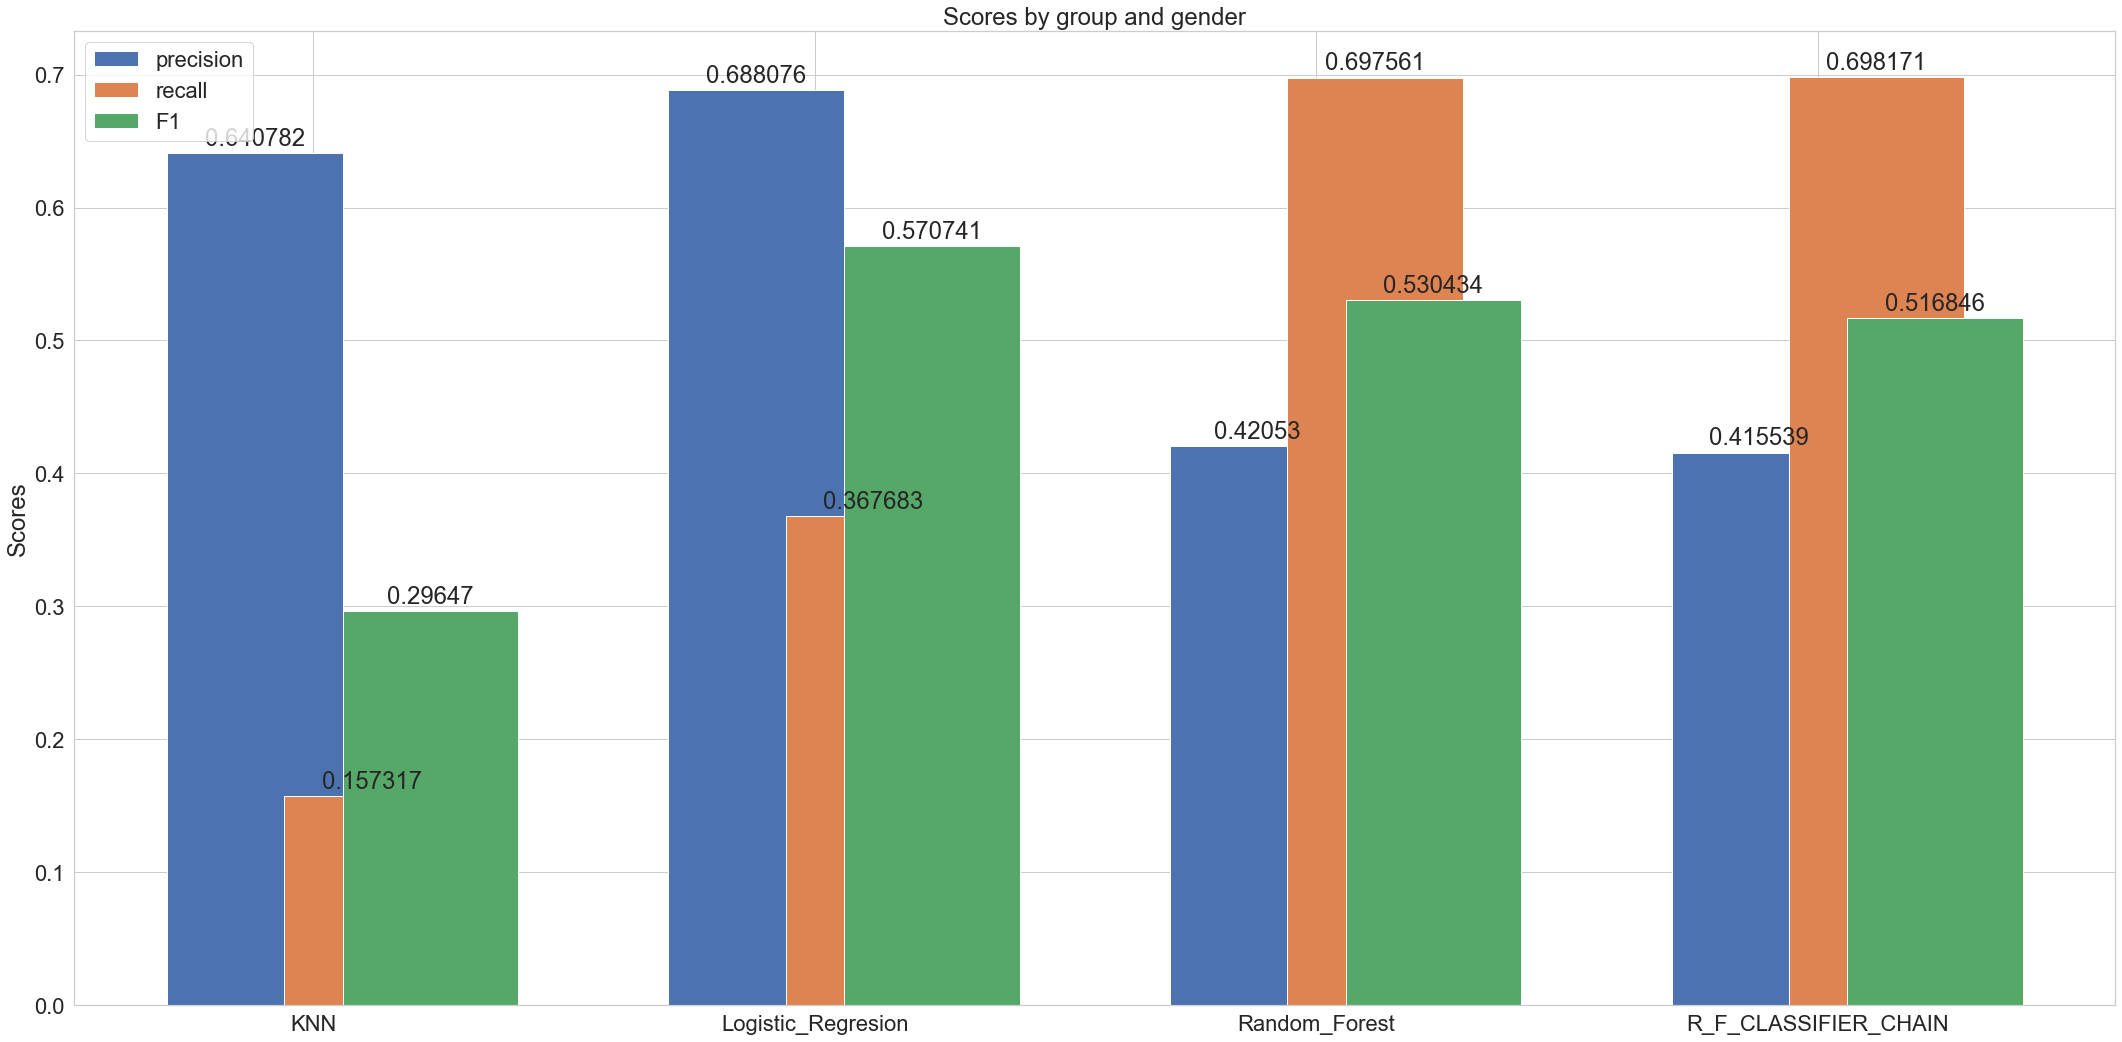

In [234]:
x = np.arange(4)  # the label locations
fig = plt.figure(figsize= (30,15))
width = 0.35  # the width of the bars
ax = fig.add_subplot()
rects_precision = ax.bar(x - width/3, general_perf["eval_precision"], width, label='precision')
rects_recal = ax.bar(x + width/3,  general_perf["eval_recall"], width, label='recall')
rects_F1 = ax.bar(x + 2*width/3,  general_perf["eval_F1"], width, label='F1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SCORE')
ax.set_title('Perfomance ')
ax.set_xticks(x)
ax.set_xticklabels(general_perf["model"])
ax.legend()

ax.bar_label(rects_precision, padding=3)
ax.bar_label(rects_recal, padding=3)
ax.bar_label(rects_F1, padding=3)

fig.tight_layout()

plt.show()

### apercu de la dissimilarité 

[Text(0, 0, '0.182175'),
 Text(0, 0, '0.423933'),
 Text(0, 0, '0.378783'),
 Text(0, 0, '0.368209')]

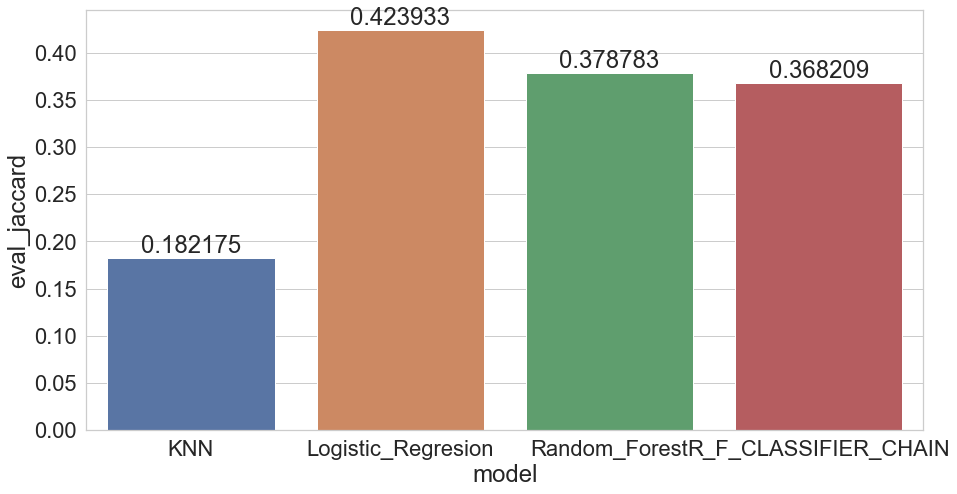

In [333]:
plt.figure(figsize= (15,17))
plt.subplot(211)
ax_jaccard = sns.barplot(x='model', y= "eval_jaccard", data = general_perf)
ax_jaccard.bar_label(ax_jaccard.containers[0])

###  preparation au  deploiement 

- vectoriser la question 
- le passer au modele 
- label_inverser du resultat 
- afficher le tag predit 

In [334]:
import joblib

In [337]:
joblib.dump(RF_best_model,"RandomForest.joblib")
joblib.dump(logit_cv,"LogisticRegression.joblib")
joblib.dump(chain_RF,"ChainClassifierRF.joblib")
joblib.dump(vectorizer,"Vectoriser.joblib")
joblib.dump(multilabel_binarizer,"MultiLabelisator.joblib")

['MultiLabelisator.joblib']

voir l'API DANS LE GITHUB